# Práctico 4:

1. Implementar un pipeline de clasificación con la muestra que se vió en clase. El código para traer el dataset es el siguiente:

Analisis del dataset MNIST

In [50]:
# Descargamos los datos:

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
print(mnist.keys())
X, y = mnist["data"], mnist["target"]

/usr/local/lib/python3.9/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


In [2]:
# Vemos las matrices

X, y = mnist["data"], mnist["target"]
X.shape                                     # Matriz de caracteristicas

(70000, 784)

In [3]:
y.shape     # Matriz de etiquetas

(70000,)

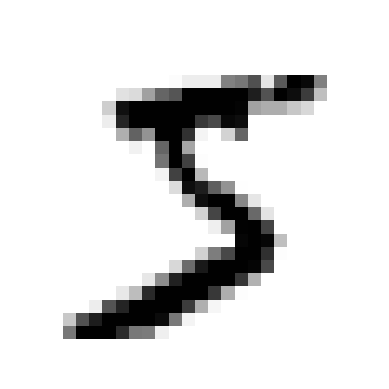

In [6]:
# Observamos la imagen de un dígito MNIST

import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [8]:
# Accedemos al primer elemento del arreglo y
# Devuelve 5, como la imagen de arriba

y[0]

'5'

In [10]:
# la etiqueta es una cadena de texto. La mayoría de los algoritmos
# de ML esperan números, así que vamos convertimos "y" a entero

import numpy as np

y = y.astype(np.uint8)

In [14]:
# Dividimos los datos segun train y test

# Lo hacemos aleatoriamente  tamaño de la prueba 
# sea el 15% del tamaño total de los datos,

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.15, random_state=42)

print("Tamaño de X_train:", X_train.shape)
print("Tamaño de X_test:", X_test.shape)
print("Tamaño de y_train:", y_train.shape)
print("Tamaño de y_test:", y_test.shape)

# Esta segunda forma es manual, dividiendo en un 60% de entrenamiento 
# y un 40% de prueba

# X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Tamaño de X_train: (59500, 784)
Tamaño de X_test: (10500, 784)
Tamaño de y_train: (59500,)
Tamaño de y_test: (10500,)


In [15]:
# Escalamos - Normalizamos
# Normalizamos los datos de entrenamiento X_train

from sklearn.preprocessing import MinMaxScaler

MinMaxScaler()
scaler = MinMaxScaler()
print(scaler.fit(X_train))
print(scaler.transform(X_train))

MinMaxScaler()
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Entrenamiento de un Clasificador Binario

In [16]:
# La siguiente funcion transforma los datos de prueba
# en enteros, pero ya lo hicimos antes

# y_train = y_train.astype('int')

In [18]:
# Creamos los vectores de destino para la tarea de clasificación

y_train_5 = (y_train == 5)  # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)


In [20]:
# Entrenamos un clasificador de descenso de gradiente estocástico (SGD)

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [21]:
# Podemos usar el clasificador para detectar si las imagenes son 5

sgd_clf.predict([X[0]])    

array([ True])

Medicion del Rendimiento o Accuracy

In [22]:
# Aplicamos validacion cruzada K-fold a nuestro modelo de clasificacion binario

from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring = "accuracy")

array([0.96763134, 0.95996571, 0.96601624])

In [23]:
# Never5Classifier es un clasificador que siempre predice "no es un 5"

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    pass
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

In [24]:
# Vemos la presicion de este modelo

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91146516, 0.90893965, 0.91020017])

In [25]:
# El siguiente pipeline hace aproximadamente lo mismo que la función cross_val_score() 
# de Scikit-Learn, e imprime el mismo resultado, mediante la clase StratifiedKFold

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=None)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred))

0.9676313401230211
0.9599657137094741
0.9660162355669843


Analisis de la Matriz de confusion

In [51]:
# Calculamos la matriza la función cross_val_predict de Scikit-Learn para realizar una 
# validación cruzada en el conjunto de entrenamiento X_train con sus etiquetas 
# correspondientes y_train_5 y un clasificador sgd_clf.


from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)
confusion_matrix(y_train_5, y_train_pred)         # Obtenemos la matriz

array([[53310,   847],
       [ 1263,  4080]])

In [29]:
# Un clasificador perfecto tendría solo verdaderos positivos y verdaderos negativos, 
# por lo que su matriz de confusión tendría valores diferentes de cero solo en su 
# diagonal principal (de arriba a la izquierda a abajo a la derecha)

y_train_perfect_predictions = y_train_5 
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54157,     0],
       [    0,  5343]])

Analisis de Presicion y Recall

In [33]:
# Calculamos las métricas de precision y recall

from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)     # Presicion

0.8280901156890603

In [34]:
recall_score(y_train_5, y_train_pred)    # Recall

0.7636159460976979

In [35]:
# Calculamos F1 score, que es la media armónica de la precisión y el recall

from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7945472249269717

Analisis de Precision/Recall trade off

In [36]:
# utilizamos el clasificador SGD previamente entrenado para hacer una predicción
# en un solo ejemplo, representado por some_digit

some_digit = X[0]
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([3156.6703652])

In [37]:
# Establecemos un umbral (threshold) para hacer la predicción de la clase de 
# instancia de prueba (some_digit) basada en los scores de decisión obtenidos
# por el clasificador SGD. 

threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred  

# Si el score de decisión para some_digit es mayor que el umbral, la predicción 
# será positiva, y si es menor que el umbral, la predicción será negativa.

array([ True])

In [38]:
# Si el puntaje de decisión es mayor que el umbral, se predice que la imagen es 
# un 5 (True), de lo contrario, se predice que no es un 5 (False).

threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [39]:
# En lugar de hacer predicciones binarias, esta función devuelve los valores 
# de score (puntuación) para cada instancia.
 
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

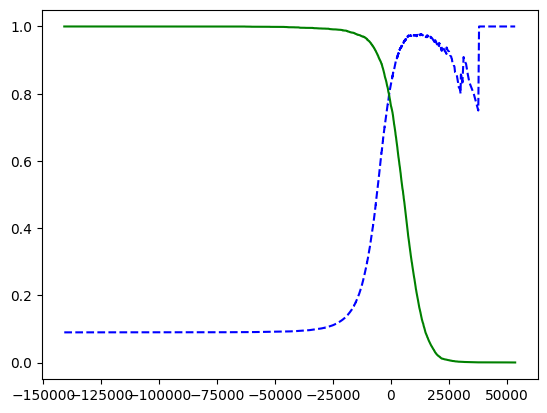

In [40]:
# Con estos puntajes calculados, utilizamos la función precision_recall_curve() 
# para calcular la precisión y la recuperación para todos los umbrales posibles

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
  plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
  [...] # highlight the threshold and add the legend, axis label, and grid


plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [41]:
#  Buscamos el valor de umbral (threshold) que produce una precisión 
# de al menos 0.90, es decir, del 90%.

threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

2242.2216938702777

In [42]:
# Hacemos predicciones, en donde si el puntaje para una instancia es mayor o igual 
# al umbral, se asigna el valor True en la predicción para esa instancia, y si es 
# menor, se asigna el valor False.

y_train_pred_90 = (y_scores >= threshold_90_precision)
y_train_pred_90

array([ True, False, False, ..., False, False, False])

In [43]:
# Comprobamos la presicion de esta prediccion

precision_score(y_train_5, y_train_pred_90)

0.9001261034047919

In [44]:
# Comprobamos el recall de esta prediccion

recall_score(y_train_5, y_train_pred_90)

0.6679767920643833

Analisis de la Curva ROC

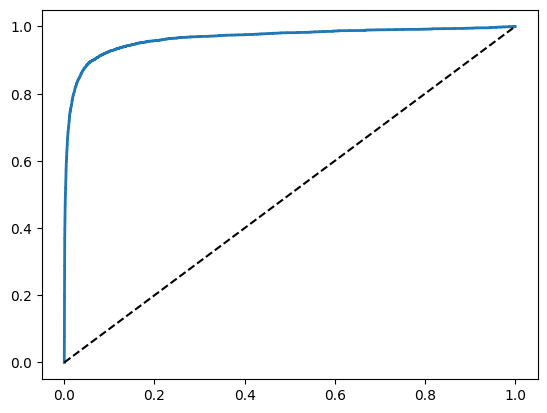

In [45]:
# Graficamos la curva ROC, para calcular la tasa de falsos positivos (FPR) y la 
# tasa de verdaderos positivos (TPR) para varios valores umbral de clasificación. 


from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
  [...] # Add axis labels and grid
  
plot_roc_curve(fpr, tpr)
plt.show()

In [46]:
# Medir el área bajo la curva (AUC). Un clasificador perfecto tendrá una ROC AUC 
# igual a 1, mientras que un clasificador aleatorio tendrá una ROC AUC igual a 0.5

from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9655057380239735

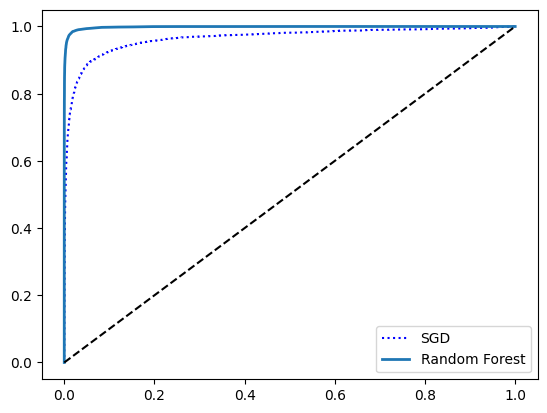

In [47]:
# Entrenamos un clasificador RandomForestClassifier y luego lo usamos para predecir 
# las probabilidades de la clase positiva en el conjunto de entrenamiento

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [49]:
# Medimos el área bajo esta nueva curva (AUC) y vemos que el resultado es mejor
# ya que casi llega a 1

roc_auc_score(y_train_5, y_scores_forest)

0.9984737275326855

Analisis de la Clasificacion Multiclase

In [52]:
# Scikit-Learn detecta cuando intentamos utilizar un algoritmo de clasificación binaria 
# para una tarea de clasificación multiclase y automáticamente ejecuta OvR u OvO, 
# dependiendo del algoritmo. Probamos esto con un clasificador de máquina de vectores 
# de soporte, utilizando la clase sklearn.svm.SVC

from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train) # y_train, not y_train_5
svm_clf.predict([some_digit])

# Cuidado, ejecucion muy pesada

array([5], dtype=uint8)

In [53]:
# Con el método decision_function(), veremos que devuelve 10 puntuaciones 
# por instancia (en lugar de solo 1)

some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72206843,  1.72846518,  7.25128076,  8.30616641, -0.31116714,
         9.3137081 ,  2.71274559,  2.78208467,  6.21734447,  4.87235478]])

In [54]:
# El puntaje más alto es de hecho el que corresponde a la clase 5

np.argmax(some_digit_scores)

5

In [55]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [56]:
svm_clf.classes_[5]

5

In [57]:
# Creamos un clasificador multiclase utilizando la estrategia OvR, 
# basado en el clasificador binario un SVC

from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

#Cuidado, ejecucion muy pesada

array([5], dtype=uint8)

In [63]:
# Imprimimos el número de clasificadores binarios que se han 
# entrenado internamente en el clasificador multiclase

len(ovr_clf.estimators_)   # Devuelve 10 puntuaciones por instancia (en lugar de solo 1)

10

In [59]:
# Ahora, entrenamos un SGDClassifie ya que es igual de facil

sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5], dtype=uint8)

In [60]:
# Vemos el puntaje que el clasificador SGD asignó a cada clase

sgd_clf.decision_function([some_digit])

array([[-26627.66110783, -49105.18858582, -11718.60999434,
         -2586.55910955, -22570.21835131,   1880.32020934,
        -28976.47157875, -12382.67420781, -10724.22863038,
         -8708.96331224]])

In [61]:
# Para evaluar el clasificador SGD usamos la validacion cruzada

cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.86755067, 0.85690516, 0.87919125])

In [62]:
# Escalamos las entradas, para que la precisión aumente por encima del 89%

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

# Cuidado, ejecucion pesada

array([0.90359988, 0.90677154, 0.8987546 ])

Analisis del Error

In [64]:
# A la matriz de confusión, la necesitamos para hacer predicciones entrenando
# los datos.  La matriz de confusión es una herramienta que muestra el número 
# de veces que se clasificó cada instancia en una clase específica y el número 
# de veces que se confundió con otras clases.

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5568,    0,   13,   10,    8,   40,   39,    6,  183,    1],
       [   1, 6372,   42,   18,    2,   37,    8,   10,  172,   10],
       [  22,   27, 5268,   81,   69,   24,   64,   46,  355,   15],
       [  25,   20,  109, 5226,    1,  192,   24,   42,  365,   56],
       [  12,   16,   44,    7, 5251,    8,   39,   27,  279,  173],
       [  31,   17,   21,  153,   50, 4427,   94,   24,  456,   70],
       [  29,   19,   54,    1,   44,   87, 5501,    9,  123,    0],
       [  21,   19,   61,   25,   42,   12,    6, 5633,  140,  224],
       [  19,   62,   40,   90,    2,  127,   30,    6, 5392,   41],
       [  25,   19,   27,   60,  130,   36,    1,  172,  308, 5093]])

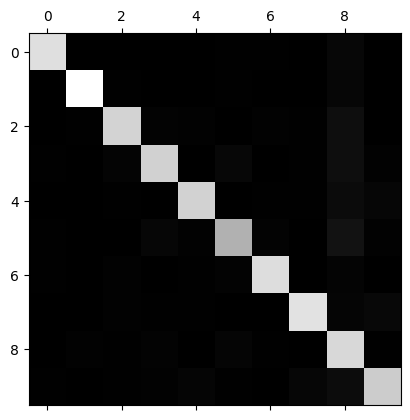

In [65]:
# Vemos una representación gráfica de la matriz de confusión

plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

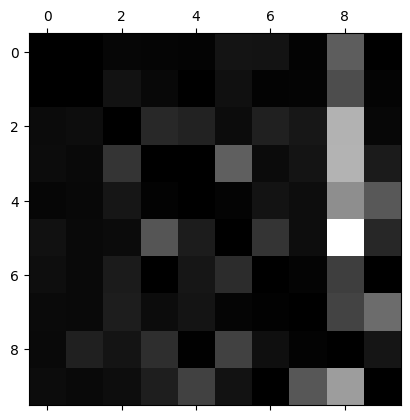

In [66]:
# Ahora, nos centramos en el gráfico de los errores. Y llenamos la 
# diagonal con ceros para mantener solo los errores y trazamos el resultado

row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [69]:
import matplotlib


def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

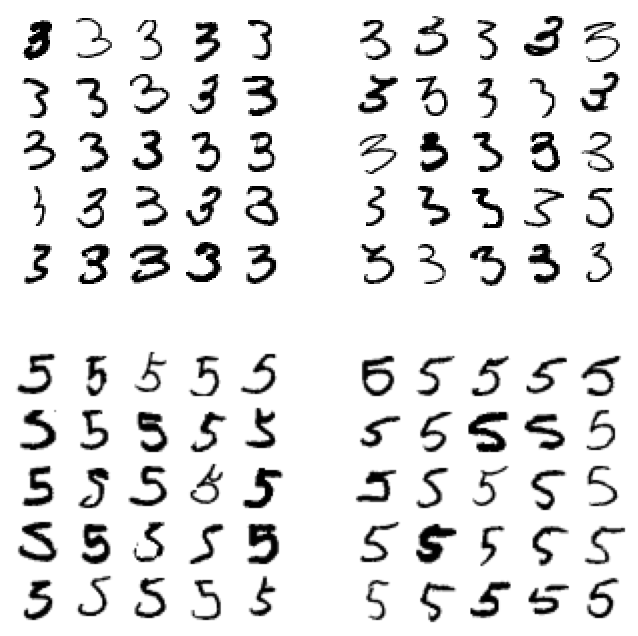

In [70]:
# Graficamos ejemplos de 3 y 5. Este análisis ayuda a comprender mejor los 
# errores del clasificador y a tomar decisiones sobre cómo mejorar su rendimiento.

cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

Clasificacion de Multiples Etiquetas

In [71]:
# Evaluamos el desempeño de un clasificador multietiqueta.
# Se quiere saber si un número es mayor a 7 e impar

from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [72]:
# El resultado que obtenemos es correcto, ya que el dígito 5 no es mayor
# o igual que 7 (False) y es impar (True).

knn_clf.predict([some_digit])

array([[False,  True]])

In [73]:
#  El siguiente código calcula el F1 score promedio en todas las etiquetas

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

#Cuidado, ejecucion muy pesada

0.9762500417941165

Clasificacion de Multiples Salidas

In [74]:
import os

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(".", fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [75]:
# Vamos a construir un sistema que elimine el ruido de las imágenes. 
# Tomará como entrada una imagen de dígito ruidosa y producirá como salida una 
# imagen del dígito limpia

noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

Saving figure noisy_digit_example_plot


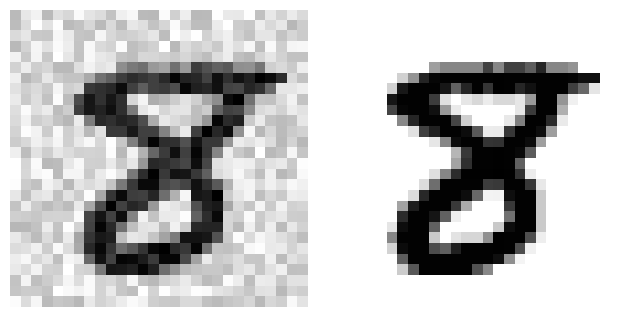

In [76]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

# Vemos en la imagen de la izquierda, que obtenemos como resultado, que está la 
# imagen de entrada con ruido y en la de la derecha está la imagen objetivo limpia.

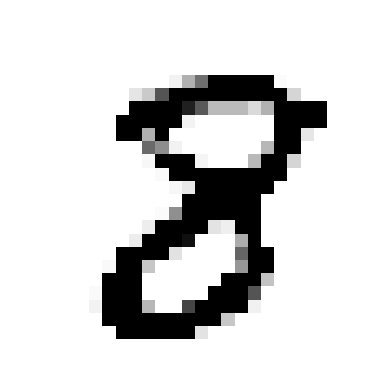

In [77]:
# Ahora entrenamos el clasificador y hacemos que limpie esta imagen

knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

2. Luego conteste las siguientes preguntas:
- ¿Que es un clasificador Binario?
- ¿Por qué un modelo con gran accuracy puede que no ser un buen modelo?
- ¿Por qué existe un trade off entre presicion y recall?
- ¿F1 es la mejor métrica que se puede utilizar al momento de optimizar un modelo? Justifique.
- ¿Para que sirve la curva ROC?


3. Utilice el clasificador KNeighborsClassifier y optimice los hiperparámetros utilizando GridSearch. ¿Qué accuracy se alcanza en el test set?

In [78]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# cargar el conjunto de datos MNIST
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]

# dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# crear un clasificador KNeighborsClassifier
knn_clf = KNeighborsClassifier()

# definir los hiperparámetros que se van a probar
param_grid = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}

# utilizar GridSearchCV para optimizar los hiperparámetros
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3)
grid_search.fit(X_train, y_train)

# obtener la precisión en el conjunto de prueba
accuracy = grid_search.score(X_test, y_test)
print("Precision en el conjunto de prueba:", accuracy)

/usr/local/lib/python3.9/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ....n_neighbors=3, weights=uniform;, score=0.969 total time=  35.8s
[CV 2/5] END ....n_neighbors=3, weights=uniform;, score=0.969 total time=  30.9s
[CV 3/5] END ....n_neighbors=3, weights=uniform;, score=0.972 total time=  32.4s
[CV 4/5] END ....n_neighbors=3, weights=uniform;, score=0.971 total time=  30.9s
[CV 5/5] END ....n_neighbors=3, weights=uniform;, score=0.970 total time=  30.9s
[CV 1/5] END ...n_neighbors=3, weights=distance;, score=0.971 total time=  32.1s
[CV 2/5] END ...n_neighbors=3, weights=distance;, score=0.970 total time=  30.9s
[CV 3/5] END ...n_neighbors=3, weights=distance;, score=0.973 total time=  30.9s
[CV 4/5] END ...n_neighbors=3, weights=distance;, score=0.972 total time=  32.3s
[CV 5/5] END ...n_neighbors=3, weights=distance;, score=0.971 total time=  30.9s
[CV 1/5] END ....n_neighbors=5, weights=uniform;, score=0.967 total time=  33.7s
[CV 2/5] END ....n_neighbors=5, weights=uniform;,

Este código importa algunas funciones y clases de los módulos sklearn.datasets, sklearn.model_selection y sklearn.neighbors. Luego, carga el conjunto de datos MNIST utilizando la función fetch_openml, que devuelve una matriz X con las imágenes y un vector y con las etiquetas correspondientes. A continuación, divide el conjunto de datos en entrenamiento y prueba utilizando la función train_test_split.

Luego, se crea un objeto de clasificador KNeighborsClassifier() y se definen los hiperparámetros que se van a probar utilizando un diccionario en param_grid. En este caso, se probarán los valores n_neighbors de 3, 5 y 7 y los valores weights de "uniform" y "distance".

Después, se utiliza GridSearchCV para optimizar los hiperparámetros. GridSearchCV es una herramienta para buscar en una cuadrícula de posibles combinaciones de hiperparámetros y seleccionar la mejor combinación según una medida de rendimiento. En este caso, se utilizó una validación cruzada de 5 pliegues (cv=5) y se habilitó el modo de verbosidad (verbose=3) para obtener información detallada sobre el proceso de búsqueda.

Finalmente, se evalúa el rendimiento o accuracy del modelo utilizando el conjunto de prueba y se imprime la precisión obtenida en el conjunto de prueba.